In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib_inline.backend_inline as backend_inline
from torchsummary import summary

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [3]:
# Create Gaussian blurs with varying widths and occluding bars
nGauss = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

# Vary the width smoothly
widths = np.linspace(2, 20, nGauss)

# Initialize tensor containing Gaussian blur images
images = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):
    # Create Gaussian blur
    ro = 1.5 * np.random.randn(2) # ro => Random offset
    G = np.exp(-((X - ro[0])**2 + (Y - ro[1])**2) / (widths[i]))

    # And add some noise
    G = G + np.random.randn(imgSize, imgSize) / 5

    # Add random bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))

    if np.random.randn() > 0:
        G[i1 : i1 + i2,] = 1
    else:
        G[:, i1 : i1 + i2] = 1

    # Add to the tensor images
    images[i, : , : , :] = torch.tensor(G).view(1, imgSize, imgSize)

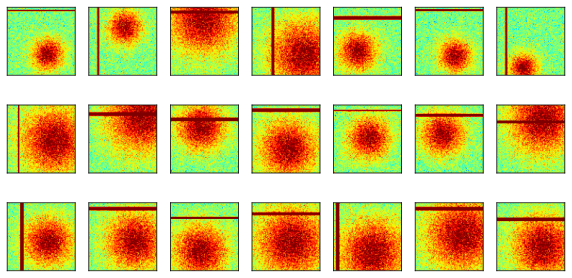

In [5]:
# visualize some images
fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [8]:
# Create the CNN Autoencoder model
def create_model():
    class CNN_AE_Gauss(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoder
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(6, 4, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            )

            # Decoder
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4, 6, 3, 2),
                nn.ReLU(),
                nn.ConvTranspose2d(6, 1, 3, 2),
            )
        def forward(self, x):
            x = self.enc(x)
            x = self.dec(x)
            return x
        
    # Model instance
    net = CNN_AE_Gauss().to(device)

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    # Loss function
    lossFun = nn.MSELoss()

    return net, optimizer, lossFun


Output shape: torch.Size([10, 1, 91, 91])


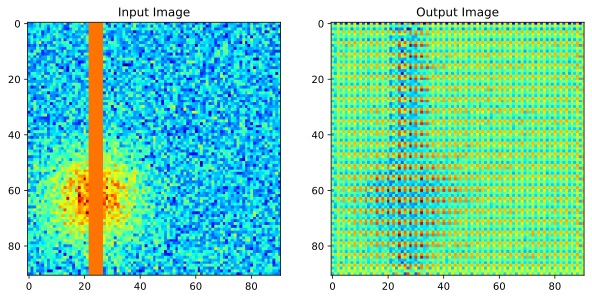

In [9]:
net, optimizer, lossFun = create_model()

yHat = net(images[:10, : , :, :])

# Check the size of the output
print("Output shape:", yHat.shape)

# Let's visualize the output of the model
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(torch.squeeze(images[0, 0, :, :]).cpu().detach(), cmap="jet")
axs[0].set_title("Input Image")
axs[1].imshow(torch.squeeze(yHat[0, 0, :, :]).cpu().detach(), cmap="jet")
axs[1].set_title("Output Image")
plt.show()

In [10]:
# Model summary
summary(net, (1, imgSize, imgSize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

In [11]:
# Create the function to train the model
def function_train_the_model( nGauss, images, epochs=500, batch_size=32):
    # Create the Model
    net, optimizer, lossFun = create_model()

    # Initialize losses
    losses = torch.zeros(epochs)

    # Loop over epochs
    for epoch in range(epochs):

        # Pick random set of images
        pics_for_training = np.random.choice(nGauss, size=batch_size, replace=False)
        X = images[pics_for_training, :, :, :]

        # Forward pass and loss
        yHat = net(X)
        loss = lossFun(yHat, X)
        losses[epoch] = loss.cpu().item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # End of epochs
    print("Training complete")
    return net, losses

In [22]:
# Model Training
net, losses = function_train_the_model(nGauss, images, epochs=1500, batch_size=32)

Training complete


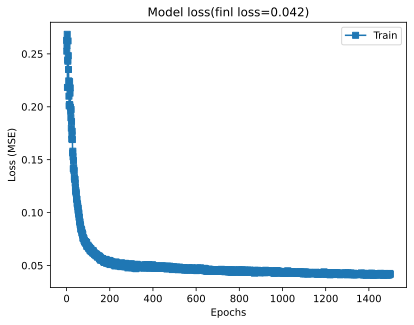

In [23]:
plt.plot(losses.cpu(), 's-', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title('Model loss(finl loss=%.3f)' % losses[-1].cpu().item())
plt.legend()
plt.show()

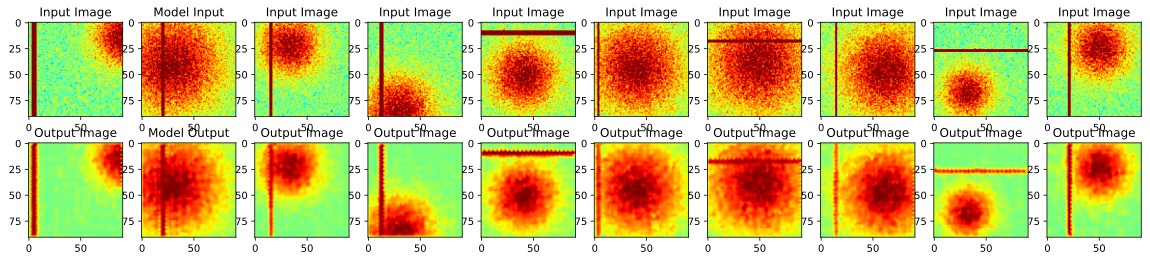

In [24]:
# Visualize some images and compare with the output of the model
pics_for_training = np.random.choice(nGauss, size=32, replace=False)
X = images[pics_for_training, :, :, :]
yHat = net(X)

fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    G = torch.squeeze(X[i, 0, :, :]).cpu().detach()
    O = torch.squeeze(yHat[i, 0, :, :]).cpu().detach()
    axs[0, i].imshow(G, vmin=-1, vmax=1, cmap="jet")
    axs[0, i].set_title("Input Image")
    axs[0, 1].set_title("Model Input")

    axs[1, i].imshow(O, vmin=-1, vmax=1, cmap="jet")
    axs[1, i].set_title("Output Image")
    axs[1, 1].set_title("Model Output")
plt.show() 